In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import optuna
import shap

from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, f1_score, classification_report
from sklearn.utils import resample

from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb

In [ ]:
carac22 = pd.read_csv("carcteristiques-2022.csv",sep=';', decimal=',')
lieux22 = pd.read_csv("lieux-2022.csv",sep=';', decimal=',')
veh22 = pd.read_csv("vehicules-2022.csv",sep=';')
vict22 = pd.read_csv("usagers-2022.csv",sep=';')

/tmp/ipython-input-3358001114.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  lieux22 = pd.read_csv("lieux-2022.csv",sep=';', decimal=',')


In [ ]:
carac23 = pd.read_csv("caract-2023.csv",sep=';', decimal=',')
lieux23 = pd.read_csv("lieux-2023.csv",sep=';', decimal=',')
veh23 = pd.read_csv("vehicules-2023.csv",sep=';')
vict23 = pd.read_csv("usagers-2023.csv",sep=';')

In [ ]:
#carac24 = pd.read_csv("caract-2024.csv",sep=';', decimal=',')
#lieux24 = pd.read_csv("lieux-2024.csv",sep=';', decimal=',')
#vict24 = pd.read_csv("usagers-2024.csv",sep=';')

Mapping des variables. D'après le dictionnaire de données issu du site data.gouv

In [ ]:
df_caract_types = {
    'dep': 'string',
    'com': 'string',
    'adr': 'string',
    'lat': 'float',
    'long': 'float',
}

carac22 = carac22.astype(df_caract_types)
carac23 = carac23.astype(df_caract_types)
#carac24 = carac24.astype(df_caract_types)


df_lieux_types = {
    'voie': 'string',
    'v2': 'string',
    'nbv': 'string',
    'pr': 'string',
    'pr1': 'string',
    'lartpc': 'float',
    'larrout': 'float'
}

lieux22 = lieux22.astype(df_lieux_types)
lieux23 = lieux23.astype(df_lieux_types)
#lieux24 = lieux24.astype(df_lieux_types)


df_veh_types = {
    'id_vehicule': 'string',
    'num_veh': 'string',
}

veh22 = veh22.astype(df_veh_types)
veh23 = veh23.astype(df_veh_types)


df_vict_types = {
    'id_usager': 'string',
    'id_vehicule': 'string',
    'num_veh': 'string',
    'actp': 'string'
}

vict22 = vict22.astype(df_vict_types)
vict23 = vict23.astype(df_vict_types)
#vict24 = vict24.astype(df_vict_types)

In [ ]:
infos_carac = pd.concat([carac22, carac23])
infos_lieux = pd.concat([lieux22, lieux23])
infos_veh = pd.concat([veh22, veh23])
infos_vict = pd.concat([vict22, vict23])

In [ ]:
#infos_carac = pd.concat([carac22_23,carac24])
#infos_lieux = pd.concat([lieux22_23,lieux24])
#infos_vict = pd.concat([vict22_23,vict24])

Jointure des datasets

In [ ]:
victime = infos_vict.merge(infos_veh,on=['Num_Acc','num_veh'])
accident = infos_carac.merge(infos_lieux,on = 'Num_Acc')
victime = victime.merge(accident,on='Num_Acc')

#1. Exploration : Analyse de la distribution, valeurs manquantes.

Classement des variables ayant le plus de valeurs nulles

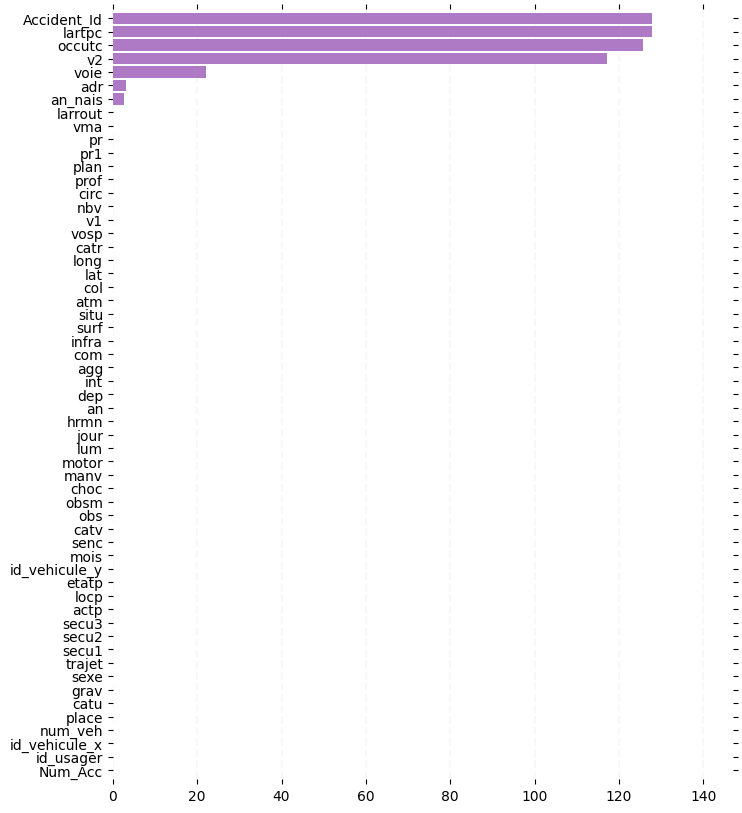

In [ ]:
nan_values = victime.isna().sum()

nan_values = nan_values.sort_values(ascending=True)*100/127951

ax = nan_values.plot(kind='barh',
                     figsize=(8, 10),
                     color='#AF7AC5',
                     zorder=2,
                     width=0.85)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both",
               which="both",
               bottom="off",
               top="off",
               labelbottom="on",
               left="off",
               right="off",
               labelleft="on")

vals = ax.get_xticks()

for tick in vals:
  ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

Suppresion des variables ayant un nombre excessif de veurs nulles

In [ ]:
nans = ['Accident_Id', 'lartpc', 'occutc', 'v2', 'voie']

victime = victime.drop(columns = nans)

In [ ]:
victime.shape

(163683, 52)

In [ ]:
victime = victime.dropna()

In [ ]:
victime.shape

(156159, 52)

Suppresion des varaibles inutiles : ids, adresse, commune (ces variables apportent du bruit)

In [ ]:
to_drop = ['id_usager', 'id_vehicule_x', 'id_vehicule_y', 'adr', 'com']
victime = victime.drop(columns = to_drop)

Diagramme de la distribution sur la variable cible

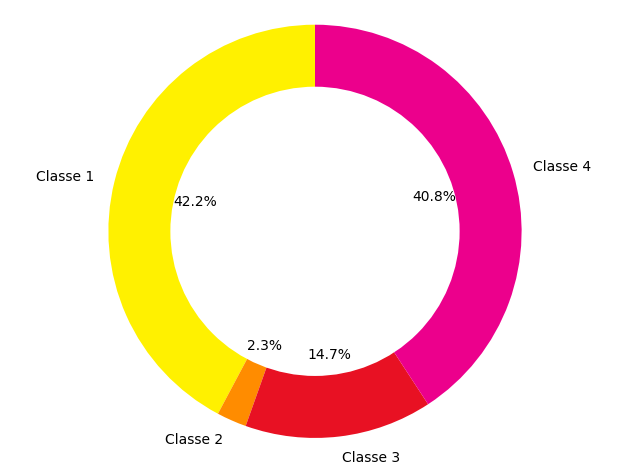

In [ ]:
labels = ['Classe 1','Classe 2','Classe 3','Classe 4']
sizes = values

#Couleurs

colors =['#fff100','#ff8c00','#e81123','#ec008c']

# Construction du diagramme et affichage des labels et des #fréquences en pourcentage

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

# Tracé du cercle au milieu

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Affichage du diagramme

ax1.axis('equal')
plt.tight_layout()
plt.show()

Discrétisation de la variable 'hrmn' : passage du format 'heure:minute' à un format catégorielle allant de 0 à 23

In [ ]:
victime['hrmn'] = victime['hrmn'].apply(lambda x: int(str(x).split(':')[0])).astype(int)
hrmn = pd.cut(victime['hrmn'], 24, labels=[str(i) for i in range(0, 24)])

In [ ]:
victime['hrmn']=hrmn.values

#2. Feature Engineering : Variables temporelles, agrégations, interactions

Clustering à partir des latitudes et longitudes pour grouper les individus du dataset selon 15 zones geographiques

In [ ]:
X_lat = victime['lat']
X_long = victime['long']

X_cluster = np.array((list(zip(X_lat, X_long))))

clustering = KMeans(n_clusters=15, random_state=0)

clustering.fit(X_cluster)

geo = pd.Series(clustering.labels_)
victime['geo']=geo

Création de variable temporelles : harmonisation de la variabe 'an', création d'indicateur jour de la semaine/ jour du weekend, calcul de l'age de l'individu



In [ ]:
victime['an_complet'] = victime['an'].apply(lambda x: 2000 + x if x < 100 else x)
victime['date_temp'] = pd.to_datetime(
    victime['an_complet'].astype(str) + '-' + victime['mois'].astype(str) + '-' + victime['jour'].astype(str),
    errors='coerce'
)
victime['day_of_week'] = victime['date_temp'].dt.dayofweek # 0=Lundi
victime['is_weekend'] = victime['day_of_week'].isin([5, 6]).astype(int) # Samedi/Dimanche

# Calcul de l'age
victime['age'] = victime['an_complet'] - victime['an_nais']
victime['age'] = victime['age'].fillna(victime['age'].median())

In [ ]:
y = victime['grav']
values = np.unique(y,return_counts=True)[1]

#3. Modélisation : Random Forest, XGBoost, LightGBM avec SMOTE & Optimisation : Hyperparamètres avec Optuna

Encodage des variables

In [ ]:
y = victime['grav']

features = ['catu','sexe','trajet',
            'catv','an_nais','mois',
            'obs','obsm','choc','manv',
            'lum','agg','int','atm','col',
            'catr','circ','vosp','prof','plan',
            'surf','infra','situ','hrmn','geo']

encoder = OrdinalEncoder()

cols_cat = [
    'num_veh',
    'actp',
    'dep',
    'nbv',
    'pr',
    'pr1'
]

victime[cols_cat] = encoder.fit_transform(victime[cols_cat])

In [ ]:
cols_cat = [
    'catu', 'sexe', 'trajet', 'catv', 'obs', 'obsm', 'choc',
    'manv', 'lum', 'agg', 'int', 'atm', 'col', 'catr',
    'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ',
    'geo', 'dep', 'actp'
]

cols_num = [
    'an_nais', 'mois', 'hrmn', 'lat', 'long', 'nbv', 'pr', 'pr1'
]

features = cols_cat + cols_num

X = victime[features].copy()

# Convert hrmn to numeric before filling NaNs if it's categorical
if 'hrmn' in X.columns and isinstance(X['hrmn'].dtype, pd.CategoricalDtype):
    X['hrmn'] = X['hrmn'].astype(int)

# Robustly convert all columns in cols_num to numeric, coercing errors
for col in cols_num:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

X[cols_cat] = X[cols_cat].fillna("Inconnu")
X[cols_num] = X[cols_num].fillna(-1)

# Explicitly cast integer-like numerical columns to int
int_like_cols = ['an_nais', 'mois', 'hrmn', 'nbv', 'pr', 'pr1']
for col in int_like_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)

encoder = OrdinalEncoder()

X[cols_cat] = encoder.fit_transform(X[cols_cat].astype(str))

y = victime['grav']

print("Taille de X :", X.shape)

Taille de X : (156159, 32)


In [ ]:
X_train_data = X

In [ ]:
y.shape, X_train_data.shape

((156159,), (156159, 32))

In [ ]:
# X_train_data['nbv']=victime['nbv'] # Removed as it was redundant and potentially problematic

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y, test_size=0.2, random_state=42, stratify=y)

Smote pour palier au déséquilibre sur y

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(f"Taille avant SMOTE: {X_train.shape}")
print(f"Taille après SMOTE: {X_train_resampled.shape}")

Taille avant SMOTE: (124927, 32)
Taille après SMOTE: (210968, 32)


Modèle n°1 : RandomForest

Accuracy: 0.7468621926229508
F1-Score: 0.7412611891182702


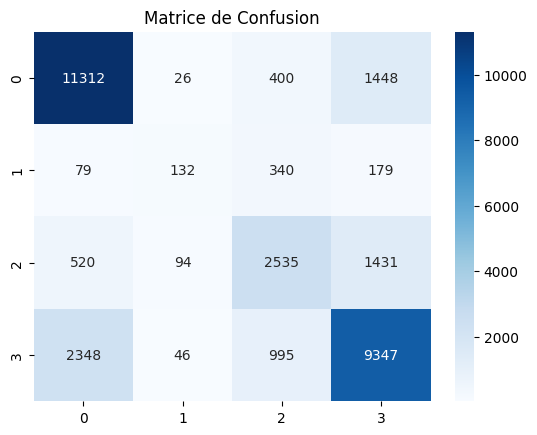

              precision    recall  f1-score   support

           1       0.79      0.86      0.82     13186
           2       0.44      0.18      0.26       730
           3       0.59      0.55      0.57      4580
           4       0.75      0.73      0.74     12736

    accuracy                           0.75     31232
   macro avg       0.65      0.58      0.60     31232
weighted avg       0.74      0.75      0.74     31232



In [ ]:
# Entraînement sur données rééquilibrées
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)

# Prédiction
y_pred = rf_model.predict(X_test)

# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted')) #

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.show()

# Rapport
print(classification_report(y_test, y_pred))

Optimisation des hyperparamètres pour le modèle RandomForest

[I 2025-12-04 09:32:19,437] A new study created in memory with name: no-name-9033d931-2baa-4c12-80b8-15a4cf333ee8
[I 2025-12-04 09:34:35,267] Trial 0 finished with value: 0.7186340610935724 and parameters: {'n_estimators': 147, 'max_depth': 35, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7186340610935724.
[I 2025-12-04 09:37:07,797] Trial 1 finished with value: 0.6920471840175687 and parameters: {'n_estimators': 204, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7186340610935724.
[I 2025-12-04 09:40:46,889] Trial 2 finished with value: 0.6965626066661246 and parameters: {'n_estimators': 230, 'max_depth': 39, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7186340610935724.
[I 2025-12-04 09:43:40,909] Trial 3 finished with value: 0.6834712521972985 and parameters: {'n_estimators': 167, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 7}. Best is trial 0 with va


Meilleurs paramètres trouvés : {'n_estimators': 147, 'max_depth': 35, 'min_samples_split': 11, 'min_samples_leaf': 1}
Meilleur F1-Score : 0.7186

Random Forest : Modèle Optimisé Final
Accuracy Optimisée: 0.7255
F1-Score Optimisé: 0.7186


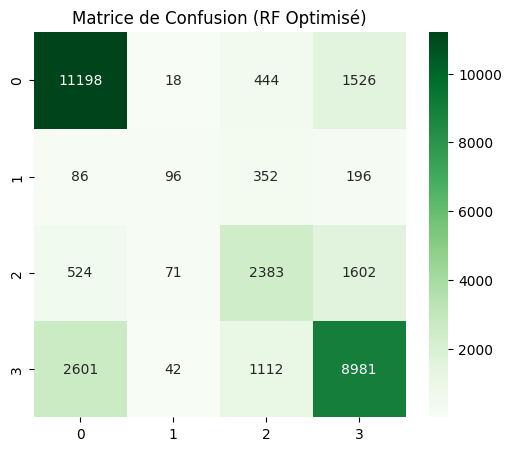

              precision    recall  f1-score   support

           1       0.78      0.85      0.81     13186
           2       0.42      0.13      0.20       730
           3       0.56      0.52      0.54      4580
           4       0.73      0.71      0.72     12736

    accuracy                           0.73     31232
   macro avg       0.62      0.55      0.57     31232
weighted avg       0.72      0.73      0.72     31232



In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective_rf(trial):
    # Espace de recherche des hyperparamètres
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # On fixe les paramètres techniques
        'n_jobs': -1,
        'random_state': 42
    }

    # Création du modèle avec les paramètres
    clf = RandomForestClassifier(**params)

    # Entraînement dataset rééchantillonné via SMOTE
    clf.fit(X_train_resampled, y_train_resampled)

    # Prédiction sur le Test set
    preds_opt = clf.predict(X_test)

    # On optimise le F1-Score Weighted (car classes déséquilibrées dans le test)
    return f1_score(y_test, preds_opt, average='weighted')

# Lancement de l'étude
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10)

print(f"\nMeilleurs paramètres trouvés : {study_rf.best_params}")
print(f"Meilleur F1-Score : {study_rf.best_value:.4f}")


# Entrainement final avec les meilleures paramètres
print("\nRandom Forest : Modèle Optimisé Final")

# Récupération des meilleurs hyperparamètres
best_params_rf = study_rf.best_params

# Entraînement du modèle final
best_rf_model = RandomForestClassifier(**best_params_rf, n_jobs=-1, random_state=42)
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Prédictions finales
y_pred_opt = best_rf_model.predict(X_test)

# Évaluation Finale
print(f"Accuracy Optimisée: {accuracy_score(y_test, y_pred_opt):.4f}")
print(f"F1-Score Optimisé: {f1_score(y_test, y_pred_opt, average='weighted'):.4f}")

# Matrice de confusion
plt.figure(figsize=(6, 5))
cm_opt = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens')
plt.title('Matrice de Confusion (RF Optimisé)')
plt.show()

# Rapport
print(classification_report(y_test, y_pred_opt))

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_data, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


XGBoost

Accuracy : 0.6770
F1-Score : 0.6684

Rapport de Classification :
              precision    recall  f1-score   support

           1       0.73      0.84      0.78     13186
           2       0.23      0.19      0.21       730
           3       0.51      0.39      0.44      4580
           4       0.68      0.64      0.66     12736

    accuracy                           0.68     31232
   macro avg       0.54      0.51      0.52     31232
weighted avg       0.67      0.68      0.67     31232



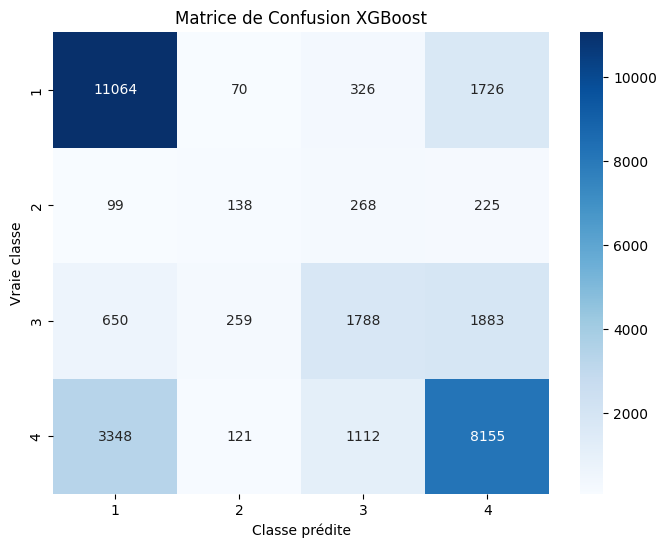

In [ ]:
model_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train_resampled, y_train_resampled)


y_pred = model_xgb.predict(X_test)

# Métriques globales
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Rapport détaillé par classe
print("\nRapport de Classification :")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_]))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion XGBoost')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()


Optimisation des hyperparamètres du modèle XGBoost

[I 2025-12-04 13:03:02,919] A new study created in memory with name: no-name-bf03525a-90b0-49cf-bce7-c44c88728e25
[I 2025-12-04 13:03:29,826] Trial 0 finished with value: 0.667607650301872 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.0414688841281643, 'subsample': 0.6453543823841066, 'colsample_bytree': 0.9100872908574885, 'min_child_weight': 6}. Best is trial 0 with value: 0.667607650301872.
[I 2025-12-04 13:03:49,609] Trial 1 finished with value: 0.672360663229383 and parameters: {'n_estimators': 191, 'max_depth': 4, 'learning_rate': 0.19622522871957016, 'subsample': 0.8558939098895899, 'colsample_bytree': 0.6814799405060722, 'min_child_weight': 3}. Best is trial 1 with value: 0.672360663229383.
[I 2025-12-04 13:05:22,630] Trial 2 finished with value: 0.6844976891507101 and parameters: {'n_estimators': 285, 'max_depth': 10, 'learning_rate': 0.021887439666620864, 'subsample': 0.8175154763996306, 'colsample_bytree': 0.9406083713930182, 'min_child_weight': 10


Meilleurs paramètres XGBoost : {'n_estimators': 336, 'max_depth': 12, 'learning_rate': 0.12110930866665152, 'subsample': 0.9880029500591642, 'colsample_bytree': 0.745229747536339, 'min_child_weight': 1}
Meilleur F1-Score : 0.7542

 XGBoost : Modèle Optimisé Final
Accuracy Optimisée : 0.7610
F1-Score Optimisé : 0.7542

Rapport de Classification (Optimisé) :
              precision    recall  f1-score   support

           1       0.81      0.87      0.84     13186
           2       0.52      0.19      0.27       730
           3       0.64      0.54      0.59      4580
           4       0.75      0.76      0.76     12736

    accuracy                           0.76     31232
   macro avg       0.68      0.59      0.61     31232
weighted avg       0.75      0.76      0.75     31232



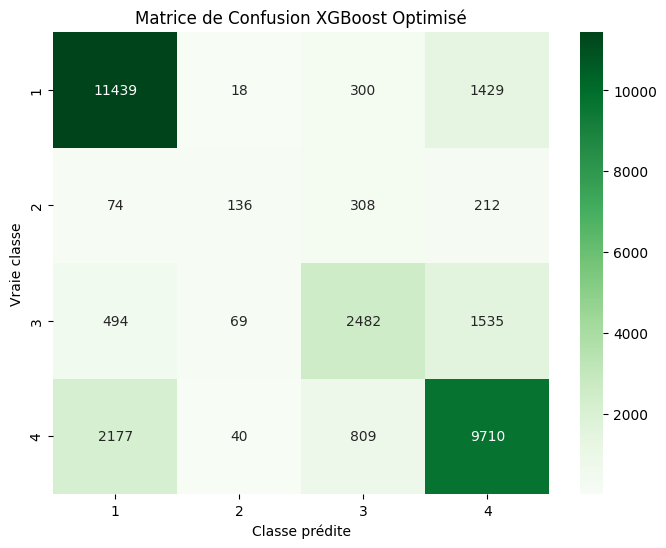

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective_xgb(trial):
    # Espace de recherche des hyperparamètres
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'multi:softmax',
        'num_class': 4,
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }

    # Création et entraînement du modèle
    model = XGBClassifier(**params)
    model.fit(X_train_resampled, y_train_resampled)

    # Prédiction sur le test set
    preds = model.predict(X_test)

    # On maximise le F1-Score Weighted
    return f1_score(y_test, preds, average='weighted')

# Lancement de l'étude
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=15)

print(f"\nMeilleurs paramètres XGBoost : {study_xgb.best_params}")
print(f"Meilleur F1-Score : {study_xgb.best_value:.4f}")

print("\n XGBoost : Modèle Optimisé Final")

# Récupération des meilleurs paramètres
best_params_xgb = study_xgb.best_params

best_params_xgb['objective'] = 'multi:softmax'
best_params_xgb['num_class'] = 4
best_params_xgb['n_jobs'] = -1
best_params_xgb['random_state'] = 42

# Entraînement final
best_xgb_model = XGBClassifier(**best_params_xgb)
best_xgb_model.fit(X_train_resampled, y_train_resampled)

# Prédictions finales
y_pred_xgb_opt = best_xgb_model.predict(X_test)

# Affichage des résultats optimisés
print(f"Accuracy Optimisée : {accuracy_score(y_test, y_pred_xgb_opt):.4f}")
print(f"F1-Score Optimisé : {f1_score(y_test, y_pred_xgb_opt, average='weighted'):.4f}")

# Rapport de classification
print("\nRapport de Classification (Optimisé) :")
print(classification_report(y_test, y_pred_xgb_opt, target_names=[str(c) for c in le.classes_]))

# Matrice de confusion
cm_xgb_opt = confusion_matrix(y_test, y_pred_xgb_opt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_opt, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion XGBoost Optimisé')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7233
[LightGBM] [Info] Number of data points in the train set: 210968, number of used features: 32
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Accuracy : 0.6829
F1-Score : 0.6739

 Rapport de Classification :
              precision    recall  f1-score   support

           1       0.74      0.83      0.78     13186
           2       0.26      0.16      0.20       730
           3       0.52      0.39      0.45      4580
           4       0.68      0.66      0.67     12736

    accuracy                           0.68     31232
   macro avg       0.55      0.51     

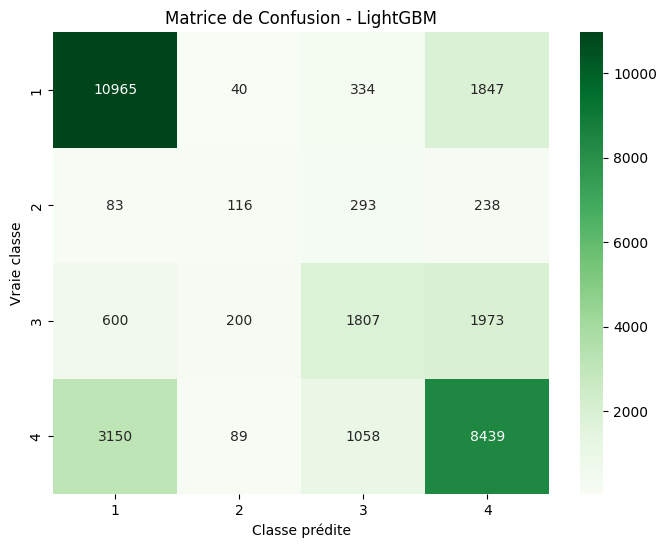

In [ ]:
model_lgbm = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    objective='multiclass',
    num_class=4,
    random_state=42,
    n_jobs=-1,
    importance_type='gain'
)

#Entrainement
model_lgbm.fit(X_train_resampled, y_train_resampled)


y_pred_lgbm = model_lgbm.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred_lgbm)
f1 = f1_score(y_test, y_pred_lgbm, average='weighted')

print(f"Accuracy : {acc:.4f}")
print(f"F1-Score : {f1:.4f}")

# Rapport détaillé
print("\n Rapport de Classification :")
print(classification_report(y_test, y_pred_lgbm, target_names=[str(c) for c in le.classes_]))

#Matrice de confusion
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion - LightGBM')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

Optimisation des hyperparamètres du modèle LightGBM

[I 2025-12-04 13:26:14,182] A new study created in memory with name: no-name-c0daf72e-f57f-4088-bd1c-f23671fbfaef
[I 2025-12-04 13:27:27,429] Trial 0 finished with value: 0.6907231981883161 and parameters: {'n_estimators': 244, 'learning_rate': 0.0629107059615994, 'num_leaves': 76, 'max_depth': 12, 'feature_fraction': 0.7873470172294419, 'bagging_fraction': 0.7880596447544005, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 0 with value: 0.6907231981883161.
[I 2025-12-04 13:28:52,570] Trial 1 finished with value: 0.6793364417141546 and parameters: {'n_estimators': 338, 'learning_rate': 0.030869281159088578, 'num_leaves': 45, 'max_depth': 12, 'feature_fraction': 0.941303594246221, 'bagging_fraction': 0.8181833709282819, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 0 with value: 0.6907231981883161.
[I 2025-12-04 13:29:28,639] Trial 2 finished with value: 0.6272118343383501 and parameters: {'n_estimators': 341, 'learning_rate': 0.026650520812556356, 'num_leaves': 


Meilleurs paramètres LightGBM : {'n_estimators': 396, 'learning_rate': 0.26808008101854747, 'num_leaves': 106, 'max_depth': 9, 'feature_fraction': 0.6009531340966647, 'bagging_fraction': 0.6062511159959277, 'bagging_freq': 6, 'min_child_samples': 25}
Meilleur F1-Score : 0.7162

 LightGBM : Modèle Optimisé Final
Accuracy Optimisée : 0.7223
F1-Score Optimisé : 0.7162

Rapport de Classification (Optimisé) :
              precision    recall  f1-score   support

           1       0.78      0.83      0.81     13186
           2       0.42      0.19      0.26       730
           3       0.57      0.49      0.53      4580
           4       0.71      0.73      0.72     12736

    accuracy                           0.72     31232
   macro avg       0.62      0.56      0.58     31232
weighted avg       0.71      0.72      0.72     31232



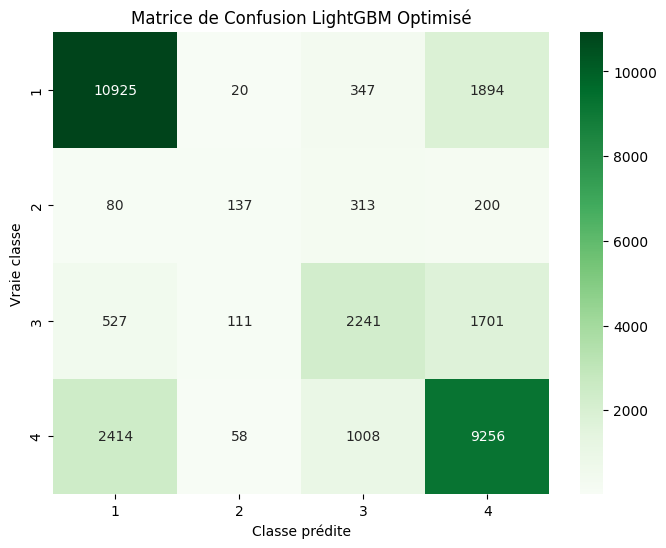

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),

        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),

        # Paramètres fixes
        'objective': 'multiclass',
        'num_class': 4,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'importance_type': 'gain'
    }

    # Instanciation et entraînement
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_resampled, y_train_resampled)

    # Prédiction
    preds = model.predict(X_test)

    # Optimisation sur le F1-Score
    return f1_score(y_test, preds, average='weighted')

# Lancement de l'étude
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=20)

print(f"\nMeilleurs paramètres LightGBM : {study_lgbm.best_params}")
print(f"Meilleur F1-Score : {study_lgbm.best_value:.4f}")


print("\n LightGBM : Modèle Optimisé Final")

# Récupération des meilleurs paramètres
best_params_lgbm = study_lgbm.best_params

# Ajout des paramètres fixes
best_params_lgbm['objective'] = 'multiclass'
best_params_lgbm['num_class'] = 4
best_params_lgbm['n_jobs'] = -1
best_params_lgbm['random_state'] = 42
best_params_lgbm['importance_type'] = 'gain'
best_params_lgbm['verbose'] = -1

# Entraînement final
best_lgbm_model = lgb.LGBMClassifier(**best_params_lgbm)
best_lgbm_model.fit(X_train_resampled, y_train_resampled)

# Prédictions finales
y_pred_lgbm_opt = best_lgbm_model.predict(X_test)

# Évaluation Optimisée
print(f"Accuracy Optimisée : {accuracy_score(y_test, y_pred_lgbm_opt):.4f}")
print(f"F1-Score Optimisé : {f1_score(y_test, y_pred_lgbm_opt, average='weighted'):.4f}")

# Rapport de classification
print("\nRapport de Classification (Optimisé) :")
print(classification_report(y_test, y_pred_lgbm_opt, target_names=[str(c) for c in le.classes_]))

# Matrice de confusion
cm_lgbm_opt = confusion_matrix(y_test, y_pred_lgbm_opt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm_opt, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion LightGBM Optimisé')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

#4. Interprétabilité : SHAP values et feature importance

Nombre de features : 32
Nombre d'importances : 32

Top 20 features les plus importantes :
    feature    importance
23     actp  84729.424156
3      catv  66800.326740
24  an_nais  52267.755832
5      obsm  39893.119575
27      lat  38595.714950
28     long  37045.241711
4       obs  35763.302093
22      dep  33685.652985
9       agg  31643.028610
7      manv  31625.406130
6      choc  30950.226321
1      sexe  29467.658326
31      pr1  27052.267357
30       pr  25964.210138
12      col  24944.681624
26     hrmn  23556.056818
0      catu  22001.754078
21      geo  19080.297955
2    trajet  18886.051497
20     situ  17287.744617


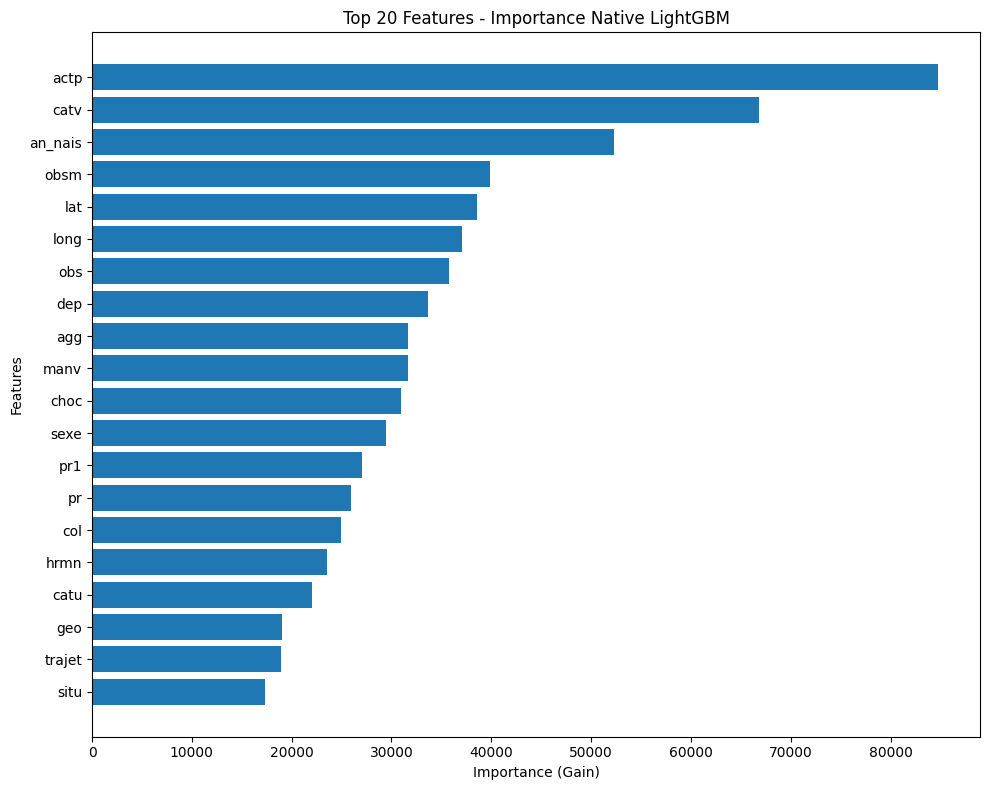

Calcul des SHAP values sur 1000 échantillons du test set...

2.2 SHAP Values par classe de gravité

Classe 1 : Classe 1 (Indemne)


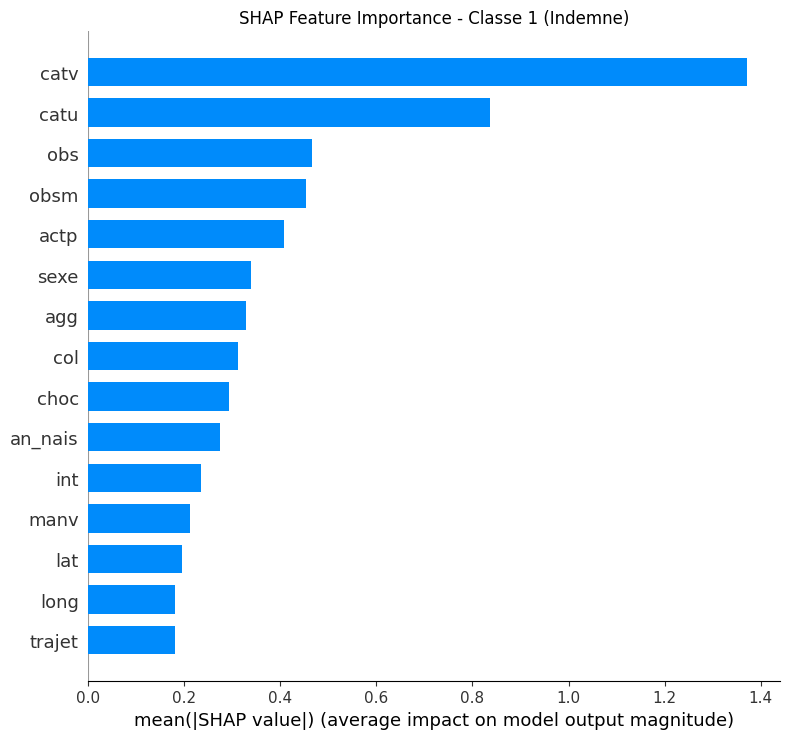


Classe 2 : Classe 2 (Blessé léger)


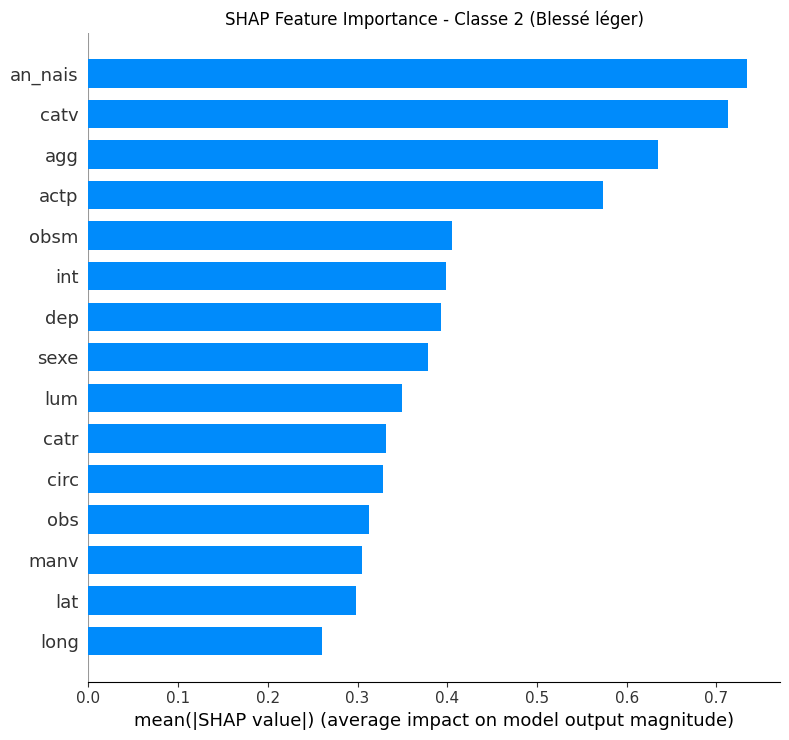


Classe 3 : Classe 3 (Blessé hospitalisé)


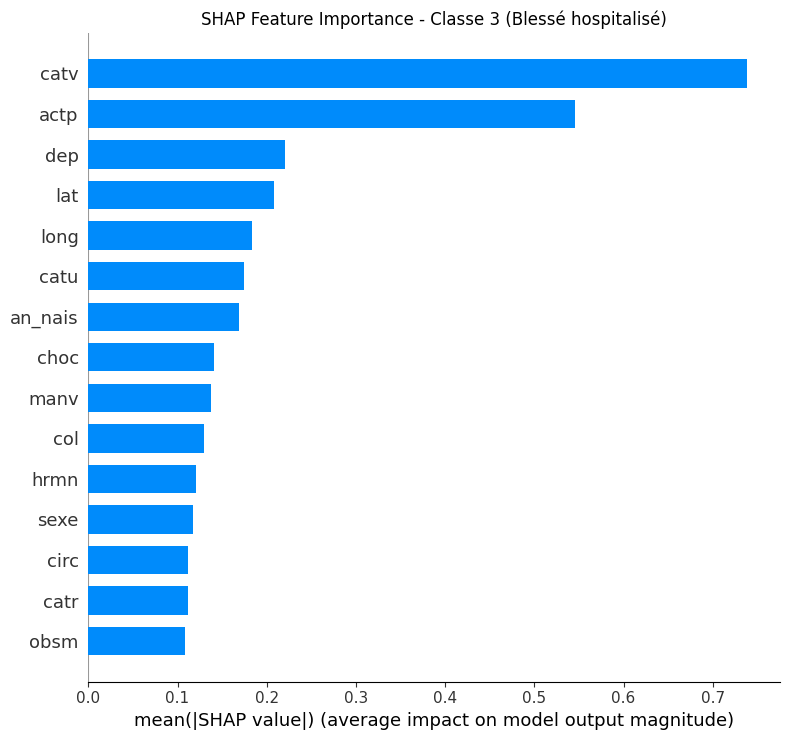


Classe 4 : Classe 4 (Tué)


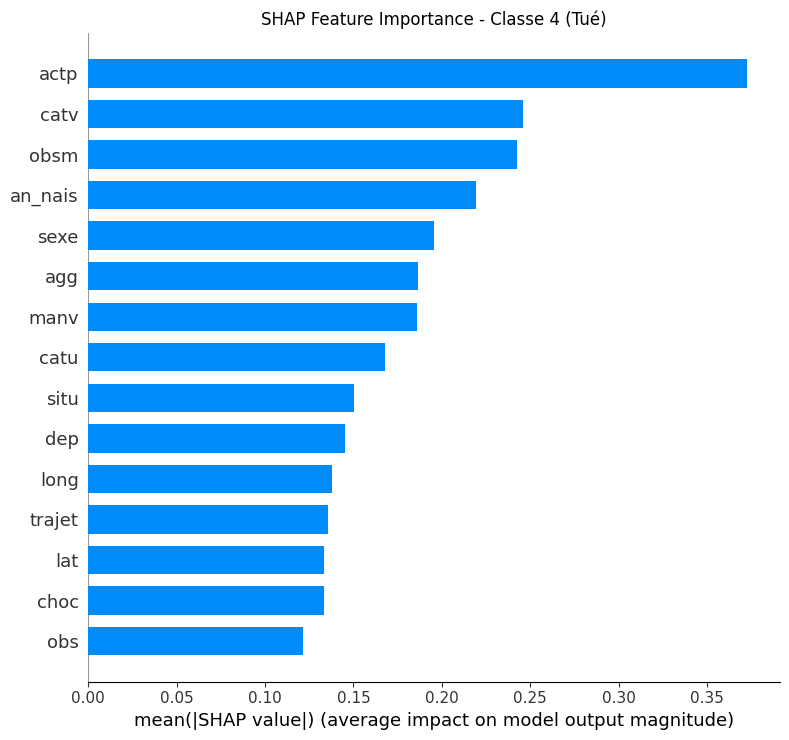

In [ ]:
# Extraction des importances
feature_importance = best_lgbm_model.feature_importances_
feature_names = X_train.columns

print(f"Nombre de features : {len(feature_names)}")
print(f"Nombre d'importances : {len(feature_importance)}")

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Affichage des top 20 features
print("\nTop 20 features les plus importantes :")
print(importance_df.head(20))

# Visualisation
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'].head(20), importance_df['importance'].head(20))
plt.xlabel('Importance (Gain)')
plt.ylabel('Features')
plt.title('Top 20 Features - Importance Native LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Création de l'explainer SHAP pour LightGBM
sample_size = min(1000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)

print(f"Calcul des SHAP values sur {sample_size} échantillons du test set...")
explainer = shap.TreeExplainer(best_lgbm_model)
shap_values = explainer(X_test_sample)


#SHAP Values par Classe
print("\n2.2 SHAP Values par classe de gravité")

class_names = ['Classe 1 (Indemne)', 'Classe 2 (Blessé léger)',
               'Classe 3 (Blessé hospitalisé)', 'Classe 4 (Tué)']

for i, class_name in enumerate(class_names):
    print(f"\nClasse {i+1} : {class_name}")

    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values[:, :, i],
        X_test_sample,
        plot_type="bar",
        show=False,
        max_display=15
    )
    plt.title(f"SHAP Feature Importance - {class_name}")
    plt.tight_layout()
    plt.show()

